In [1]:
# Make necessary imports
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
import sys
import torch
import numpy as np
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
import matplotlib.pyplot as plt
from rdkit import Chem

sys.path.append('D:\\My Documents\\projects\\drug\\')
sys.path.append("D:\My Documents\projects\drug\st\smiles_transformer")

from st.smiles_transformer.utils import split as split_method
from st.smiles_transformer.build_vocab import WordVocab

label_list = retrieve_label_name_list('herg_central')
print(label_list)
data = Tox(name = 'herg_central', label_name = label_list[1])
split = data.get_split(method = 'random', seed = 42, frac = [0.9, 0, 0.1])
seq_len = 256



vocab = WordVocab.load_vocab('D:\My Documents\projects\drug\st\smiles_transformer\data\chembl_vocab.pkl')

Downloading...


['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']


100%|█████████████████████████████████████████████████████████████████████████████| 23.6M/23.6M [01:12<00:00, 326kiB/s]
Loading...
Done!


In [2]:
# Split dataset into train and test
import pandas as pd
df = split['train'][:100000]
print(df.head())
print(df.shape)

eval_df = split['test'][0:10000]



    Drug_ID                                               Drug         Y
0  26665387        COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1  13.05888
1  26732361  COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...  17.87858
2  49735227  COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...  19.03128
3  22413685                            Fc1ccc(Oc2ncccn2)c(F)c1  13.25328
4    858163  CCCCCCn1c(O)c(C=NC2CCN(Cc3ccccc3)CC2)c(=O)[nH]... -65.74782
(100000, 3)


In [3]:
from rdkit import Chem
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from Toxicity.ToxicityDataset import ToxicityDataset

# Data processing and creation of dataset and dataloaders

df['Len'] = df['Drug'].apply(lambda x: len(list(x)))
# For herG
hmin =-70.0
hmax=30.0

# Drop rows where the length of the smiles string is longer than 250
df = df[df['Len'] <= seq_len-8]
print(df.shape)
df = df[df['Y'] <= hmax]
print(df.shape)

df = df[df['Y'] >= hmin]
print(df.shape)

train_data = ToxicityDataset(list(df['Drug']), np.array(df['Y']), vocab, randomize=False, seq_len=seq_len)
train_sampler = RandomSampler(train_data)
train_batch_size=256
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size, drop_last=True) 


eval_batch_size=256
eval_df['Len'] = eval_df['Drug'].apply(lambda x: len(list(x)))
# Drop rows where the length of the smiles string is longer than 250
eval_df = eval_df[eval_df['Len'] <= seq_len-8]
print(eval_df.shape)
eval_df = eval_df[eval_df['Y'] <= hmax]
print(eval_df.shape)

eval_df = eval_df[eval_df['Y'] >= hmin]
print(eval_df.shape)

eval_data = ToxicityDataset(list(eval_df['Drug']), np.array(eval_df['Y']), vocab, randomize=False,seq_len=seq_len) 
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size, drop_last=True)  

(100000, 4)
(99023, 4)
(97685, 4)
-0.6999761999999999 0.29995757300000003
97685 <class 'list'>
(10000, 4)
(9911, 4)
(9760, 4)
-0.6995672000000001 0.29979577
9760 <class 'list'>


In [8]:
# Create model and optimizer
import torch.nn as nn
from Toxicity.DeepToxRegressor import DeepToxRegressor

mod = DeepToxRegressor(len(vocab.stoi), embed_dim=64,seq_len=seq_len, dropout=0.3)

total_params = sum(p.numel() for p in mod.parameters())
print(f"Number of parameters: {total_params/1e6}")
print('vocab stoi', vocab.stoi)

mod = mod.cuda()
lr = 0.001 
loss = nn.MSELoss()
optimizer = torch.optim.Adam(mod.parameters(), lr=lr)
def get_accuracy(mod, data_loader):
    num_batches = 0
    loss_epoch = 0
    for idx,(a,b) in enumerate(tqdm(data_loader)):
        with torch.no_grad():
            out = mod(a.cuda())
            output = out.squeeze()
            loss_value = loss(output, b.cuda())
            loss_epoch +=loss_value
            num_batches+=1
          
    print("Loss", loss_epoch/num_batches)
    return loss_epoch/num_batches

Number of parameters: 2.152065
vocab stoi {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3, '<mask>': 4, 'c': 5, 'C': 6, '(': 7, ')': 8, 'O': 9, '1': 10, '2': 11, '=': 12, 'N': 13, '@': 14, '[': 15, ']': 16, 'n': 17, '3': 18, 'H': 19, '4': 20, 'F': 21, '-': 22, 'S': 23, 'Cl': 24, '/': 25, 's': 26, 'o': 27, '5': 28, '+': 29, '.': 30, '#': 31, 'Br': 32, '\\': 33, 'P': 34, '6': 35, 'I': 36, '7': 37, 'Na': 38, '-2': 39, '-3': 40, '8': 41, 'B': 42, '9': 43, 'Si': 44, '%10': 45, 'K': 46, '%11': 47, '-4': 48, 'Se': 49}


In [9]:
# Train the model
from tqdm import tqdm
loss_epoch = 0
num_samp= 1
loss_trn_list=[]
loss_eval_list=[]
for epoch in range(50):
    if epoch > 0:
        loss_epoch = loss_epoch.cpu().detach()/num_samp
    else:
        loss_epoch = 0
    loss_trn_list.append(loss_epoch)

    print("starting epoch", epoch, loss_epoch)
    loss_eval = get_accuracy(mod, eval_dataloader)
  
    loss_eval = loss_eval.cpu().detach()
    loss_eval_list.append(loss_eval)
    mod.train()
    loss_epoch = 0
    num_samp = 1
    for idx, (sm_idx,target) in enumerate(tqdm(train_dataloader)):
        sm_idx=sm_idx.cuda()
        target=target.cuda()
        output = mod(sm_idx)
        output = output.squeeze()
        loss_value = loss(output, target)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch +=loss_value
        num_samp+=1

starting epoch 0 0


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.73it/s]


Loss tensor(0.0708, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  9.03it/s]


starting epoch 1 tensor(0.0342)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.02it/s]


Loss tensor(0.0304, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  9.05it/s]


starting epoch 2 tensor(0.0291)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.63it/s]


Loss tensor(0.0295, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:41<00:00,  9.10it/s]


starting epoch 3 tensor(0.0279)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.50it/s]


Loss tensor(0.0292, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:41<00:00,  9.10it/s]


starting epoch 4 tensor(0.0270)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.25it/s]


Loss tensor(0.0298, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  8.91it/s]


starting epoch 5 tensor(0.0261)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  6.65it/s]


Loss tensor(0.0302, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:41<00:00,  9.14it/s]


starting epoch 6 tensor(0.0253)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.13it/s]


Loss tensor(0.0299, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  9.03it/s]


starting epoch 7 tensor(0.0242)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  7.63it/s]


Loss tensor(0.0302, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  8.96it/s]


starting epoch 8 tensor(0.0233)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  7.80it/s]


Loss tensor(0.0305, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:41<00:00,  9.16it/s]


starting epoch 9 tensor(0.0224)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.88it/s]


Loss tensor(0.0304, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:41<00:00,  9.19it/s]


starting epoch 10 tensor(0.0215)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.50it/s]


Loss tensor(0.0304, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:43<00:00,  8.83it/s]


starting epoch 11 tensor(0.0207)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  6.91it/s]


Loss tensor(0.0319, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  9.02it/s]


starting epoch 12 tensor(0.0198)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.30it/s]


Loss tensor(0.0313, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  8.96it/s]


starting epoch 13 tensor(0.0189)


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  7.00it/s]


Loss tensor(0.0317, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:42<00:00,  9.05it/s]


starting epoch 14 tensor(0.0180)


 71%|██████████████████████████████████████████████████████████▎                       | 27/38 [00:03<00:01,  7.24it/s]


KeyboardInterrupt: 

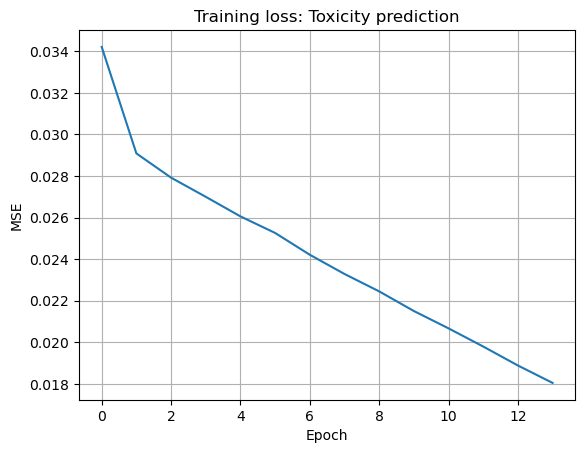

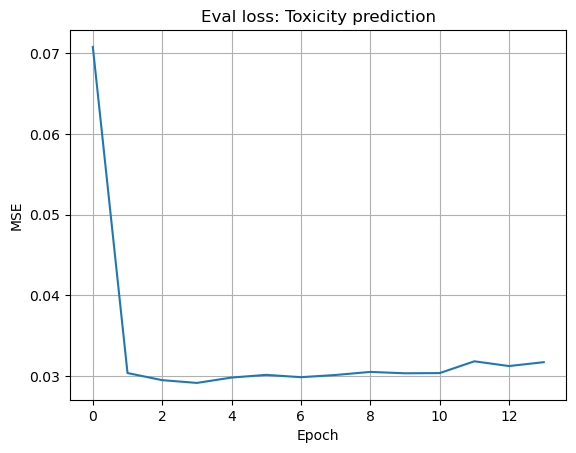

In [10]:
# Visualize loss curves
plt.plot(loss_trn_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training loss: Toxicity prediction')
plt.grid()


plt.show()
plt.plot(loss_eval_list)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Eval loss: Toxicity prediction')
plt.grid()
plt.show()

In [11]:
# Compare prediction of model with actual values (on training set)
mod.eval().cuda()
num_batches = 0
loss_epoch = 0
output_list =[]
target_list=[]
for idx,(a,b) in enumerate(train_dataloader):
        with torch.no_grad():
            out = mod(a.cuda())
            output = out.squeeze()
            loss_value = loss(output, b.cuda())
            output = output.cpu().numpy()
            target = b.cpu().numpy()
            for op,tgt in zip(output, target):
                output_list.append(op)
                target_list.append(tgt)

            loss_epoch +=loss_value
            num_batches+=1

print(loss_epoch/num_batches)


tensor(0.0145, device='cuda:0')


0.09316639


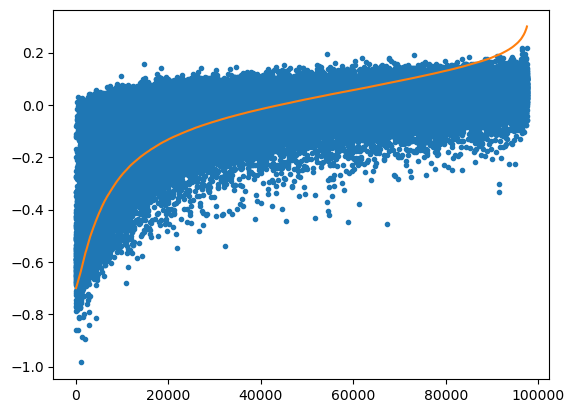

In [12]:
# Sort the eval samples by toxicity
# Pick the top 10
output_array = np.array(output_list)
target_array =np.array(target_list)
perm = [i for i in range(len(output_array))]
perm = np.argsort((target_array))
plt.plot(output_array[perm],'.')
plt.plot(target_array[perm])
print(np.mean(abs(output_array[perm]-target_array[perm])))
plt.show()
# Do the same for the model output

In [13]:
# Now save the model to disk

torch.save(mod.eval().cpu().state_dict(), 'toxicity_predictor_herG.pt')

